# Demand Forecasting Inference Pipeline

This notebook demonstrates how to make demand predictions for specific item-location combinations using trained models from the model registry.

In [23]:
# Import necessary libraries
import hopsworks
import pandas as pd
import os
import joblib
from datetime import datetime
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Configuration Parameters

Set the parameters for inference.

In [24]:
# Load environment variables
load_dotenv()

# Configure inference parameters
project_name = 'many_models'
model_name = 'demand_forecaster'
item_id = 9046137  # Item ID to predict demand for
location_id = 3     # Location ID
time_bucket = 202101  # Time period (YYYYMM format)

## Connect to Hopsworks

Establish connection to the Hopsworks model registry.

In [ ]:
print("Connecting to Hopsworks")
# Connect to Hopsworks
project = hopsworks.login(
    host=os.getenv("HOST"),
    port=os.getenv("PORT"),
    api_key_value=os.getenv("HOPSWORKS_API_KEY"),
    project=project_name or os.getenv("PROJECT")
)
mr = project.get_model_registry()

Connecting to Hopsworks
2025-05-09 10:18:28,886 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-09 10:18:28,890 INFO: Initializing external client
2025-05-09 10:18:28,891 INFO: Base URL: https://10.87.43.175:28181
2025-05-09 10:18:30,541 INFO: Python Engine initialized.

Logged in to project, explore it here https://10.87.43.175:28181/p/123


## Retrieve the Best Model

Find the best model for the specified item-location combination based on RMSE.

In [26]:
# Format model name for the specific item-location combination
model_prefix = f"{model_name}_item{item_id}_loc{location_id}"
print(f"Looking for model: {model_prefix}")

# Get the best model based on RMSE (lower is better)
model_instance = mr.get_best_model(name=model_prefix, 
                                   metric="rmse", 
                                   direction="min")
print(f"Found best model for {model_prefix} (version {model_instance.version})")

# Get model metrics
metrics = model_instance.training_metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Download the model
model_dir = model_instance.download()
print(f"Model downloaded to {model_dir}")

Looking for model: demand_forecaster_item9046137_loc3
Found best model for demand_forecaster_item9046137_loc3 (version 1)

Model Performance Metrics:
mae: 0.0190
r2: -0.0060
rmse: 0.0461


Downloading: 0.000%|          | 0/76067 elapsed<00:00 remaining<?

Model downloaded to /var/folders/gm/jcxw7_jn24q4n5hh4zchb37r0000gn/T/e168c7c4-58d0-4fb4-8039-f85e44e4b5ab/demand_forecaster_item9046137_loc3/1


## Prepare Inference Data

Create a dataframe with the time period for prediction.

In [27]:
# Create inference data for the specific time bucket
inference_data = pd.DataFrame([{
    'time_bucket': time_bucket
}])

display(inference_data)

,time_bucket
0,202101


## Make Prediction

Load the model and make a demand prediction.

In [28]:
# Load the model (supports both RandomForest and XGBoost formats)
if os.path.exists(os.path.join(model_dir, "model.joblib")):
    print("Loading RandomForest model")
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
else:
    print("Loading XGBoost model")
    import xgboost as xgb
    model = xgb.XGBRegressor()
    model.load_model(os.path.join(model_dir, "model.json"))

# Make prediction
prediction = float(model.predict(inference_data)[0])
prediction = max(0, prediction)  # Ensure non-negative

# Display the result
print(f"\nDemand Prediction Results:")
print(f"Item: {item_id}")
print(f"Location: {location_id}")
print(f"Time Period: {str(time_bucket)[:4]}-{str(time_bucket)[4:]}")
print(f"Predicted Demand: {prediction:.2f} units")

Loading XGBoost model

Demand Prediction Results:
Item: 9046137
Location: 3
Time Period: 2021-01
Predicted Demand: 0.01 units


## Visualize Prediction

Create a simple visualization of the prediction.

2025-05-09 10:18:38,409 WARNING: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




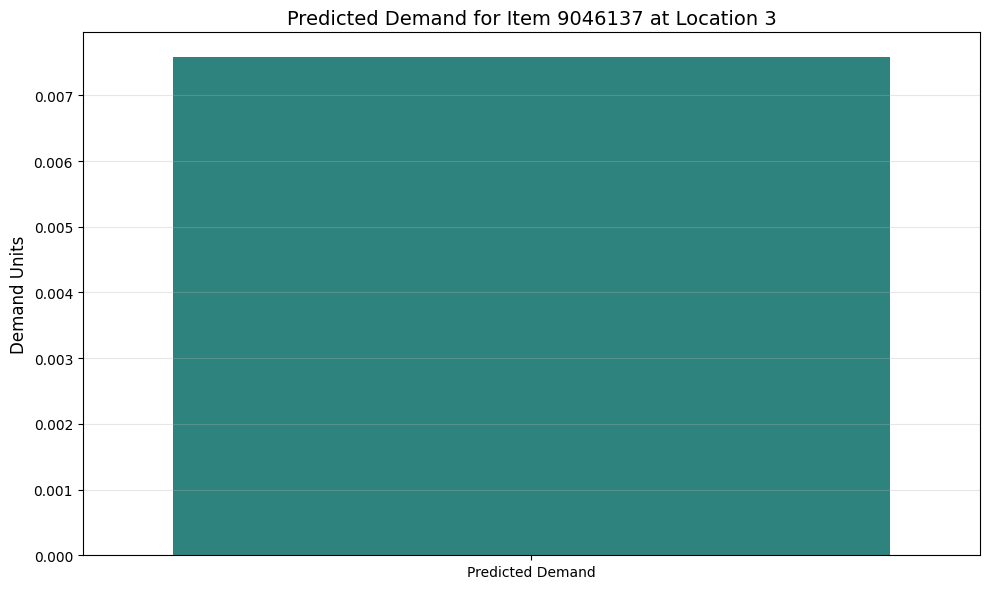

In [29]:
# Create a simple bar chart of the predicted demand
plt.figure(figsize=(10, 6))
sns.barplot(x=['Predicted Demand'], y=[prediction], palette='viridis')
plt.title(f'Predicted Demand for Item {item_id} at Location {location_id}', fontsize=14)
plt.ylabel('Demand Units', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Predicting for Multiple Time Periods

Let's predict demand across multiple time periods to see trends.

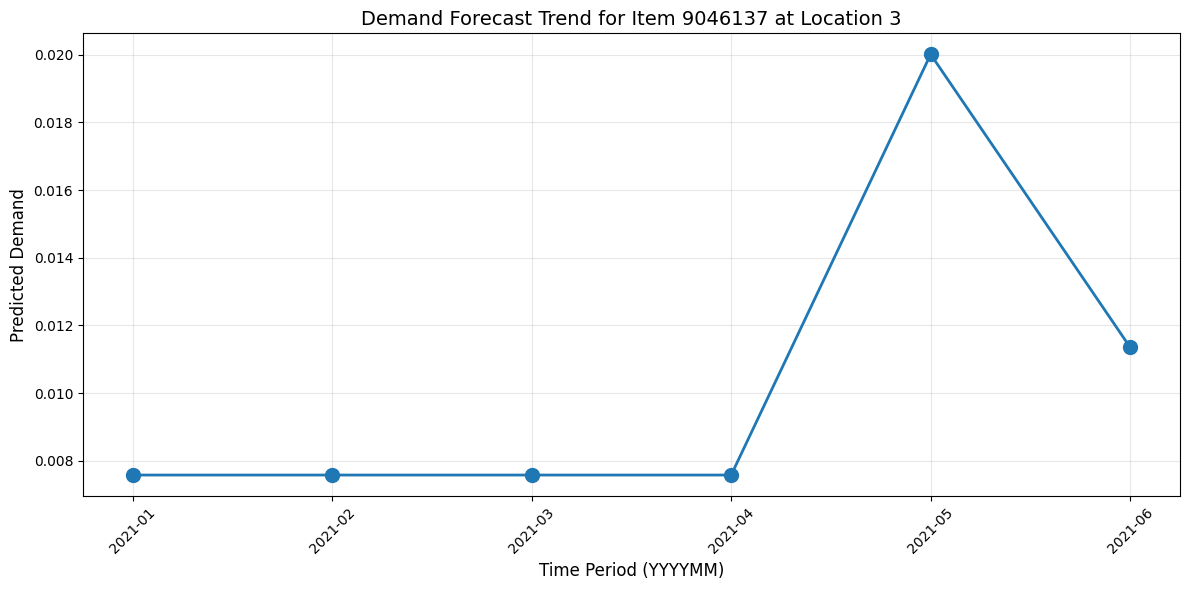

In [30]:
# Create a range of time periods to predict for
time_periods = [202101, 202102, 202103, 202104, 202105, 202106]
predictions = []

for period in time_periods:
    # Create inference data for this time period
    period_data = pd.DataFrame([{
        'time_bucket': period
    }])
    
    # Make prediction
    pred = float(model.predict(period_data)[0])
    pred = max(0, pred)  # Ensure non-negative
    predictions.append(pred)

# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(time_periods, predictions, marker='o', linestyle='-', linewidth=2, markersize=10)
plt.title(f'Demand Forecast Trend for Item {item_id} at Location {location_id}', fontsize=14)
plt.xlabel('Time Period (YYYYMM)', fontsize=12)
plt.ylabel('Predicted Demand', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(time_periods, [f"{str(p)[:4]}-{str(p)[4:]}" for p in time_periods], rotation=45)
plt.tight_layout()
plt.show()

## Batch Prediction Function

A reusable function for batch predictions across multiple items or locations.

In [21]:
def batch_predict(items, locations, time_period):
    """Predict demand for multiple item-location combinations"""
    results = []
    
    for item in items:
        for loc in locations:
            # Get model name for this item-location
            model_prefix = f"{model_name}_item{item}_loc{loc}"
            
            try:
                # Get the best model
                model_instance = mr.get_best_model(name=model_prefix, 
                                   metric="rmse", 
                                   direction="min")
                
                # Download model
                model_dir = model_instance.download()
                
                # Load the model
                if os.path.exists(os.path.join(model_dir, "model.joblib")):
                    model = joblib.load(os.path.join(model_dir, "model.joblib"))
                else:
                    import xgboost as xgb
                    model = xgb.XGBRegressor()
                    model.load_model(os.path.join(model_dir, "model.json"))
                
                # Create inference data - only need time_bucket
                inference_data = pd.DataFrame([{'time_bucket': time_period}])
                
                # Make prediction
                prediction = float(model.predict(inference_data)[0])
                prediction = max(0, prediction)  # Ensure non-negative
                
                # Store result
                results.append({
                    'item_id': item,
                    'location_id': loc,
                    'time_period': time_period,
                    'predicted_demand': prediction,
                    'rmse': model_instance.training_metrics.get("rme"),
                    'model_type': model_instance.model_schema.get('model_class', None)
                })
                
            except Exception as e:
                raise e
    
    return pd.DataFrame(results)

Downloading: 0.000%|          | 0/76067 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/498 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/79835 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/498 elapsed<00:00 remaining<?

,item_id,location_id,time_period,predicted_demand,rmse,model_type
0,9046137,3,202101,0.007579,None,None
1,9033029,3,202101,0.008352,None,None


2025-05-09 10:19:54,698 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-09 10:19:54,702 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


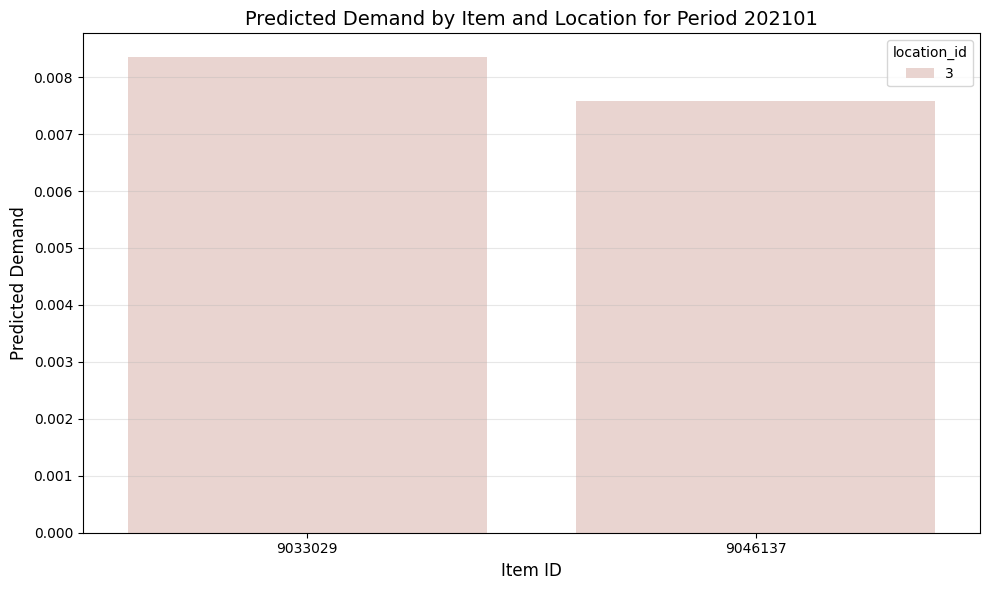

In [31]:
# Example batch prediction
items_to_predict = [9046137, 9033029]
locations_to_predict = [3]
time_period = 202101

# Run batch prediction
batch_results = batch_predict(items_to_predict, locations_to_predict, time_period)

# Display results
display(batch_results)

# Visualize batch results
if not batch_results.empty:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='item_id', y='predicted_demand', hue='location_id', data=batch_results)
    plt.title(f'Predicted Demand by Item and Location for Period {time_period}', fontsize=14)
    plt.xlabel('Item ID', fontsize=12)
    plt.ylabel('Predicted Demand', fontsize=12)
    plt.grid(axis='y', alpha=0.3)

    # Add RMSE values as annotations
    for i, row in enumerate(batch_results.itertuples()):
        if hasattr(row, 'rmse') and row.rmse is not None:
            ax.text(i, row.predicted_demand + 0.1, f'RMSE: {row.rmse:.2f}', 
                    ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()